In [1]:
import gymnasium as gym
import numpy as np
import random
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
desc=["SFFF", "FHHH", "FFFF", "HFHF", "FFGF"]

env = gym.make('FrozenLake-v1', desc=desc, map_name="5x5", is_slippery=False) 
observation, info = env.reset()

In [3]:
def calculate_percentage_change(old_q_table, new_q_table):
    """
    Calculate the percentage change in Q-values between two Q-tables.

    Parameters:
        old_q_table (numpy.ndarray): The old Q-table.
        new_q_table (numpy.ndarray): The new Q-table.

    Returns:
        float: The percentage change in Q-values.
    """
    q_diff = np.abs(new_q_table - old_q_table)
    avg_change = np.mean(q_diff)
    old_avg = np.mean(old_q_table)
    if old_avg == 0:
        return 100
    else:
        return (avg_change / old_avg) * 100

In [4]:
def runTrial():
    # Define parameters
    gamma = 0.9  # Discount factor
    alpha = 0.1  # Learning rate
    epsilon = 0.01  # Epsilon-greedy parameter
    num_episodes = 100

    # Initialize Q-values
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    Q = np.zeros((num_states, num_actions))

    statistics = pd.DataFrame({
        "Time": [],
        "Episode": [],
        "Q-Difference": [],
        "GotGift": []
    })

    # SARSA
    start_time = time.time()

    timeToConverge = 0
    
    episode = 0
    loop=True
    actions = 0
    while loop:
        state = env.reset()[0]
        done = False

        gotGift = False

        steps = []

        arr_copy = Q.copy()

        # Choose initial action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Random action
        else:
            action = np.argmax(Q[state])  # Greedy action

        while not done:


            # Take action and observe next state and reward
            steps.append(action)
            step = env.step(action)
            actions+=1
            next_state = step[0]
            reward = step[1]
            done = step[2]

            if reward == 0 and done:
                reward = -1
            elif next_state == state:
                reward = -1

            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                next_action = env.action_space.sample()  # Random action
            else:
                next_action = np.argmax(Q[next_state])  # Greedy action

            # SARSA update rule
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            if reward == 1:
#                 print("Hit gift! At Episode: "+str(episode +1))
    #             print(Q)
    #             print("Steps: ")
    #             print(steps)
                gotGift = True
                end_time = time.time()
                elapsed_time = end_time - start_time
#                 print("Elapsed time:", elapsed_time, "seconds")


            # Move to next state
            state = next_state
            action = next_action

        change = calculate_percentage_change(arr_copy, Q)
        end_time = time.time()
        elapsed_time = end_time - start_time

        statistics.loc[episode] = {
            "Time": elapsed_time,
            "Episode": episode+1,
            "Q-Difference": -change,
            "GotGift": gotGift
        }

        if -change <= 0.1 and gotGift:
            loop=False
#             print("Final time: "+str(elapsed_time))
#             print(change)
            timeToConverge = elapsed_time
        episode += 1

    # Optimal policy
    optimal_policy = np.argmax(Q, axis=1)

#     print("Optimal policy:")
#     print(optimal_policy)
    
    # Create the scatter plot
    sns.scatterplot(data=statistics, x="Time", y="Q-Difference", hue="GotGift")

    # Set the limits of x and y axes
    plt.ylim(0, 100)
    # Show the plot
    plt.show()
    
    return {
        "Time": timeToConverge,
        "Episodes": episode,
        "ActionCount": actions
    }


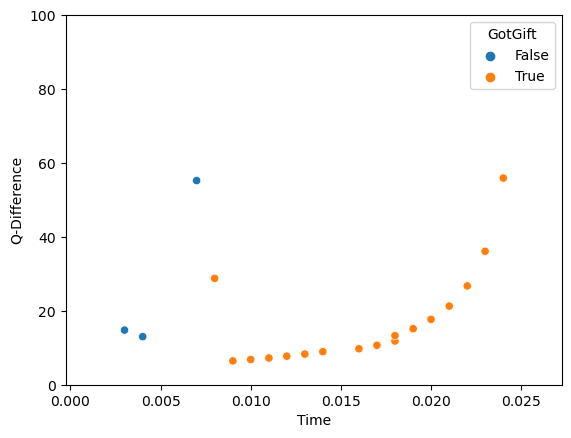

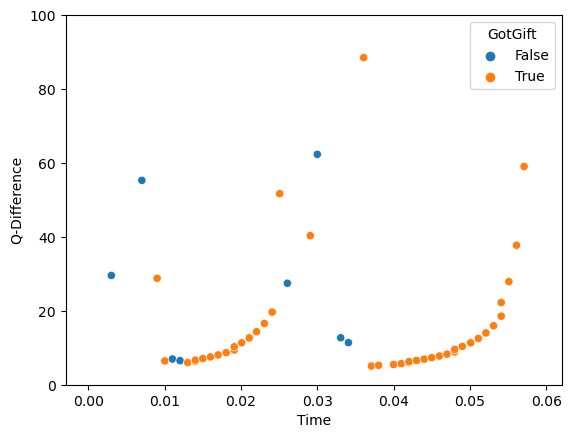

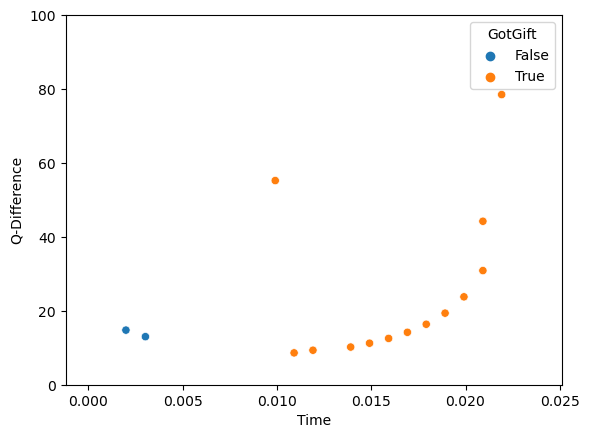

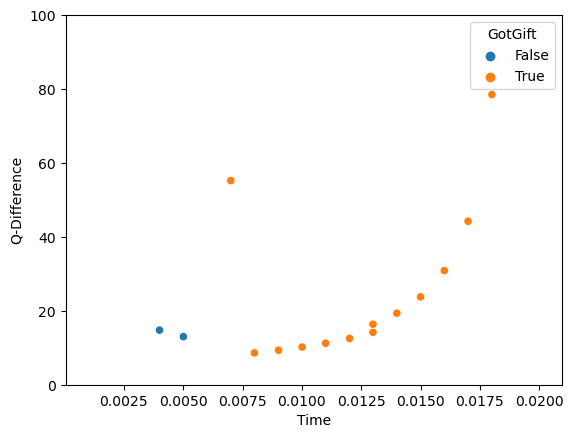

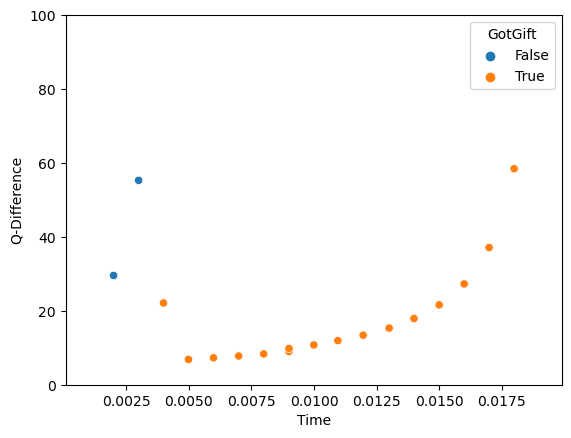

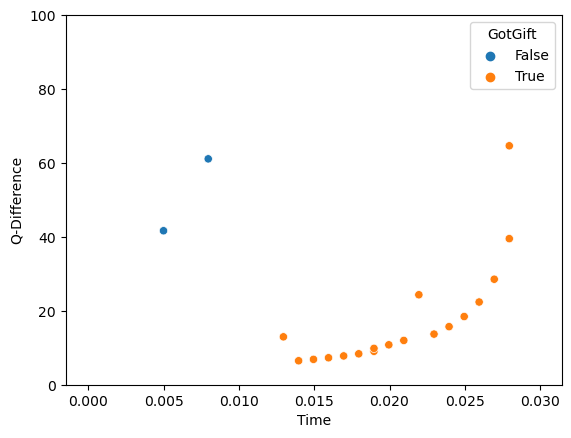

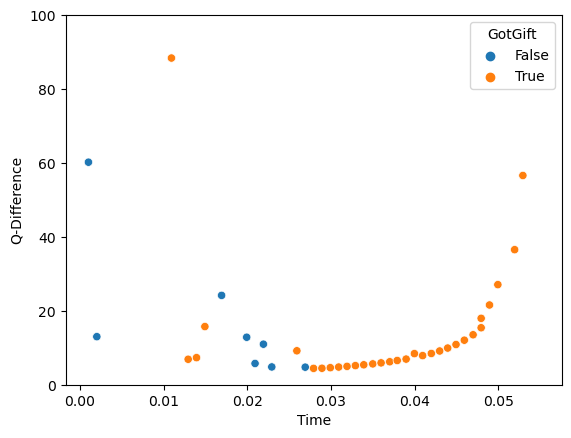

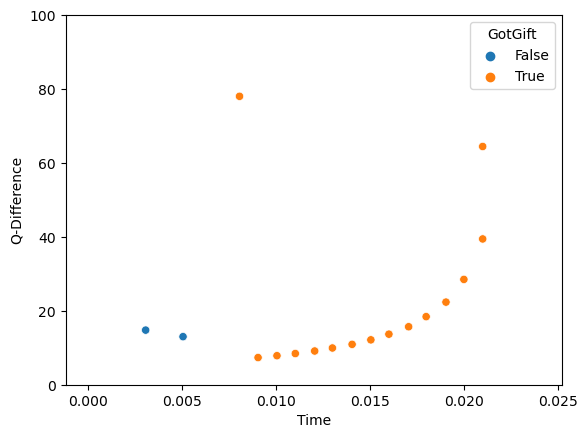

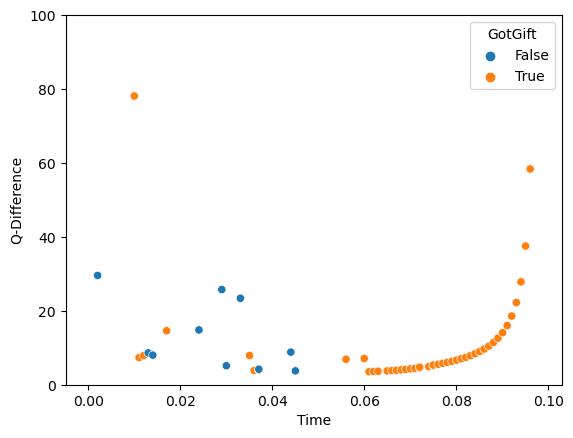

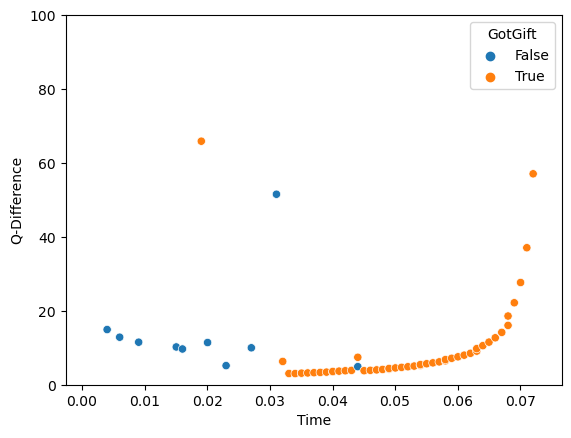

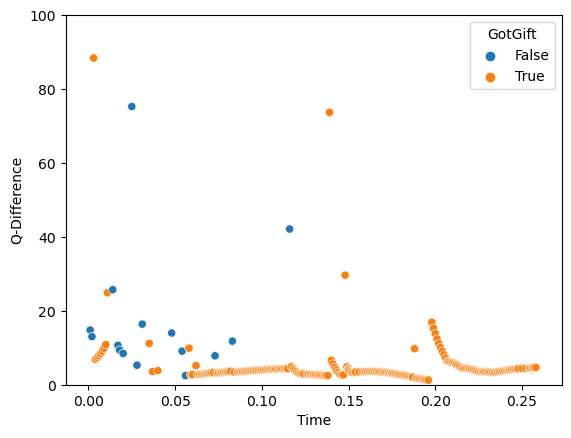

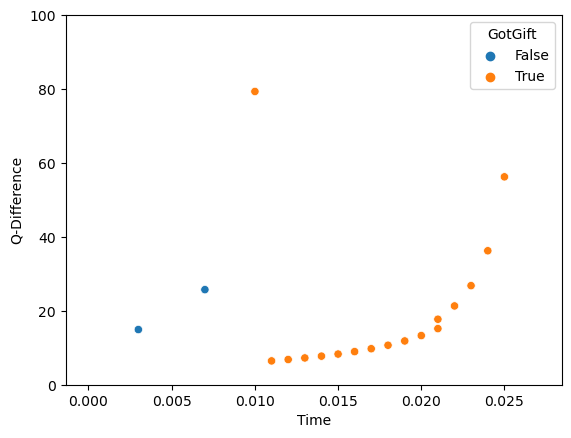

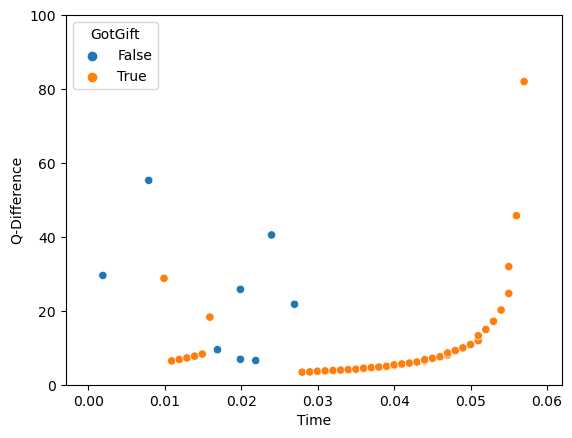

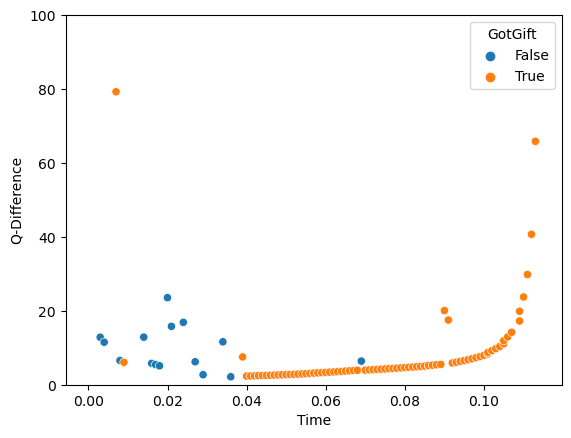

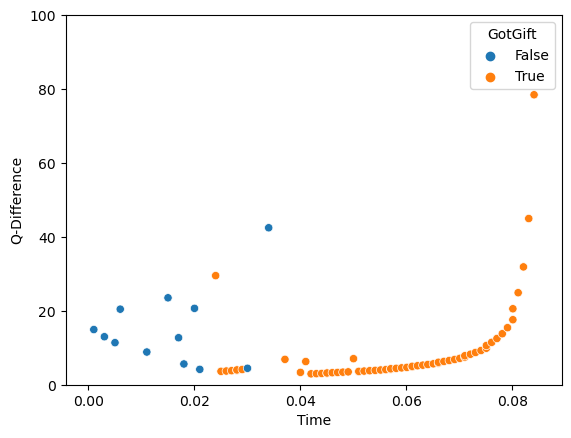

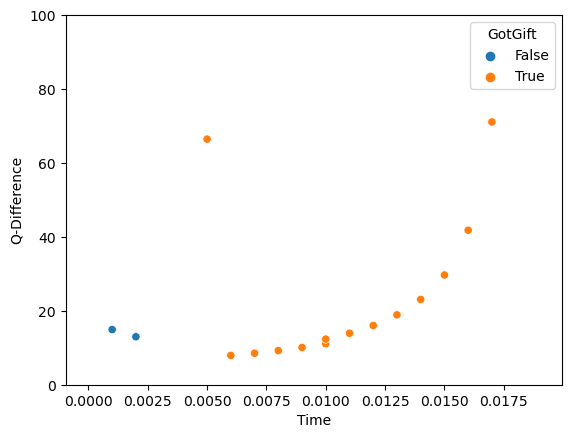

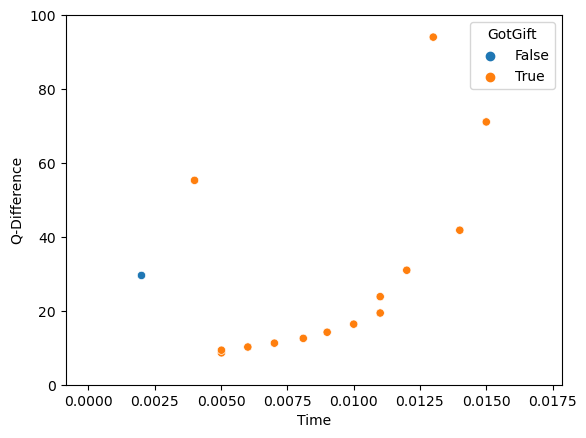

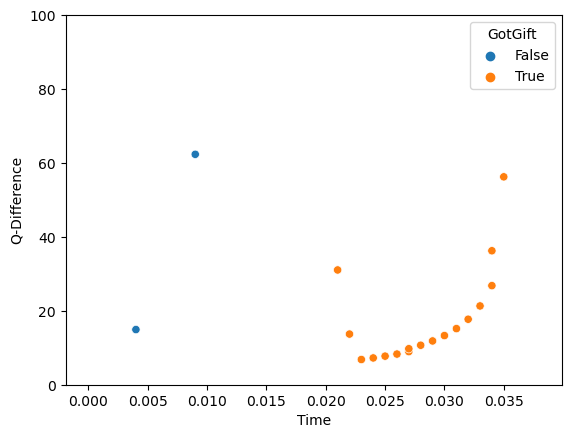

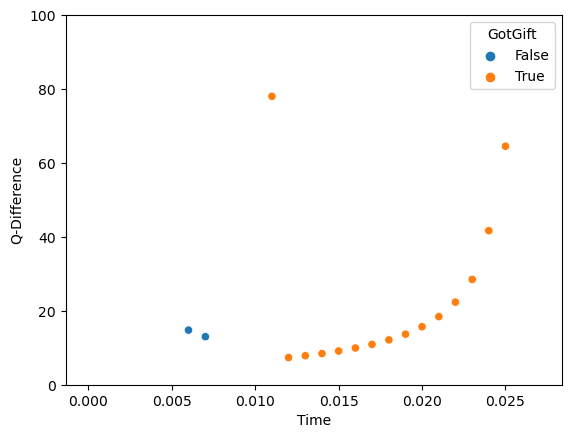

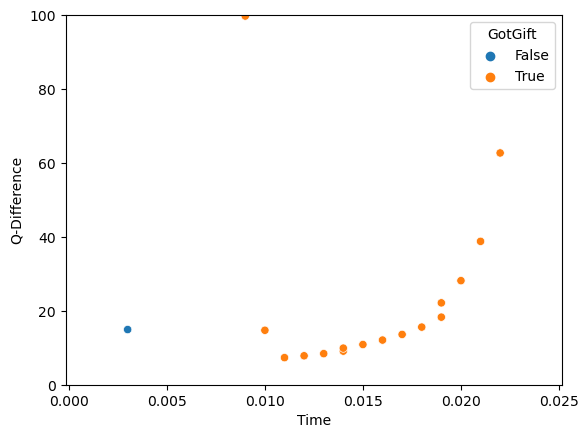

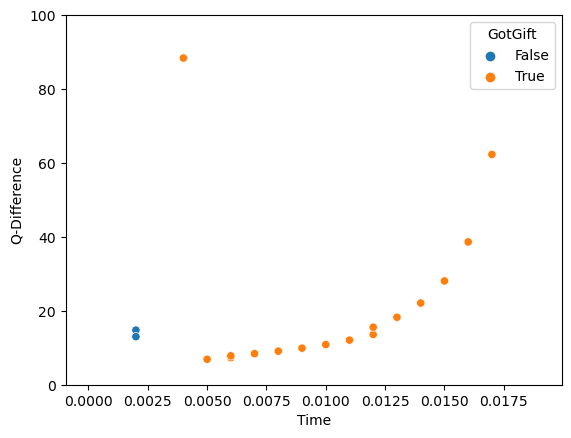

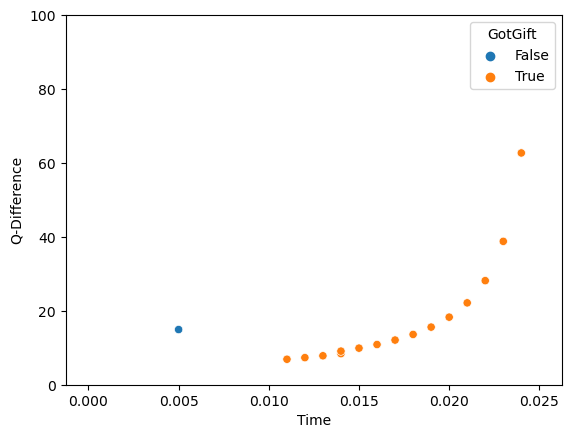

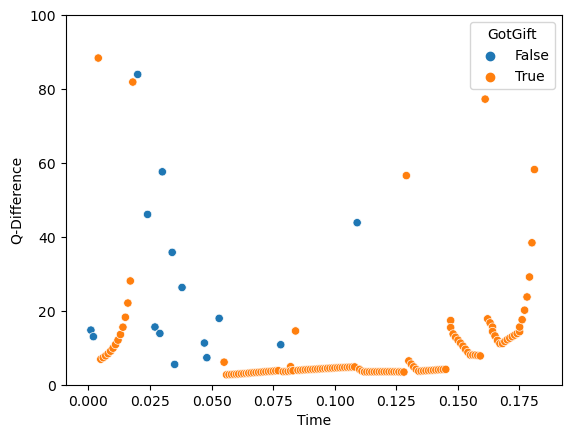

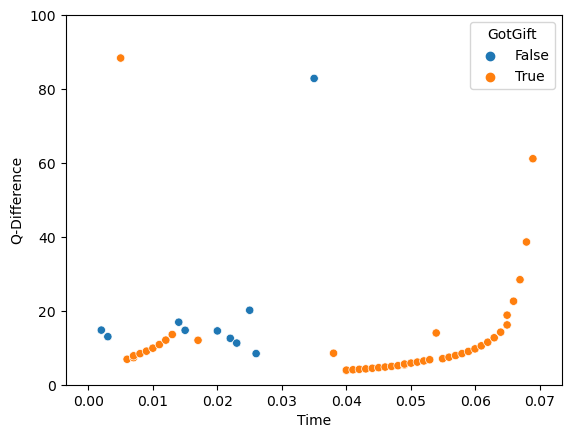

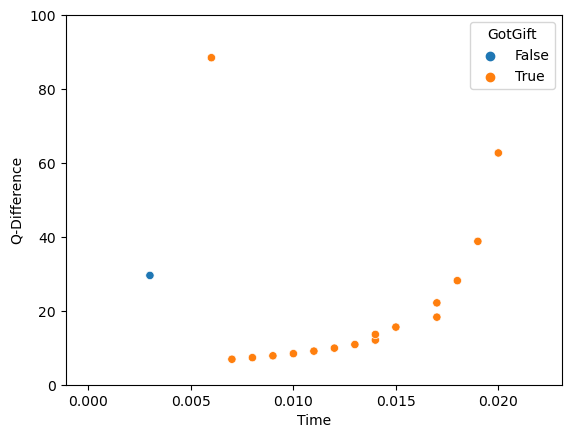

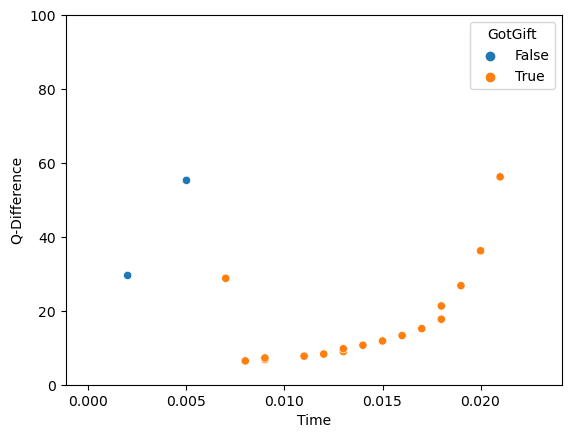

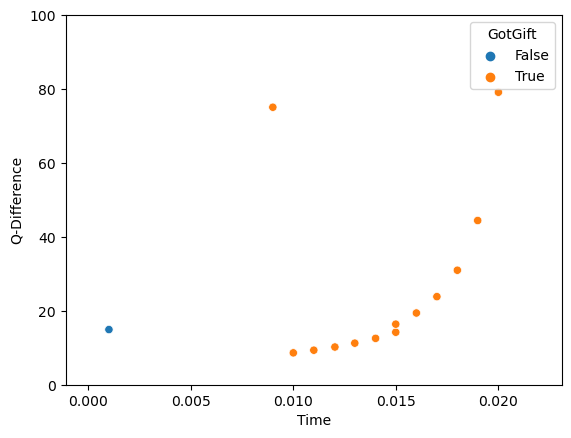

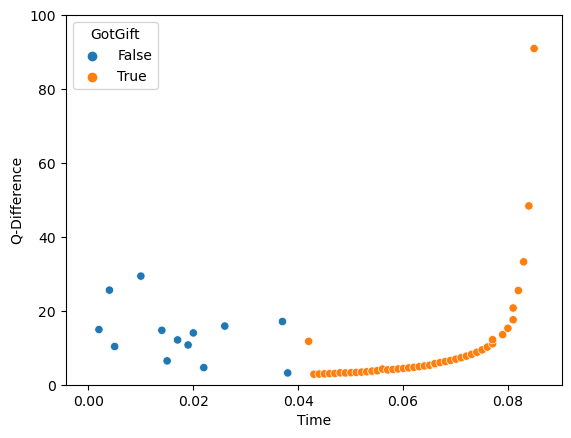

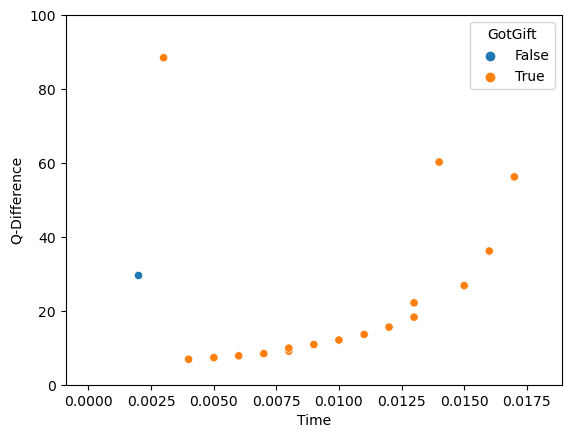

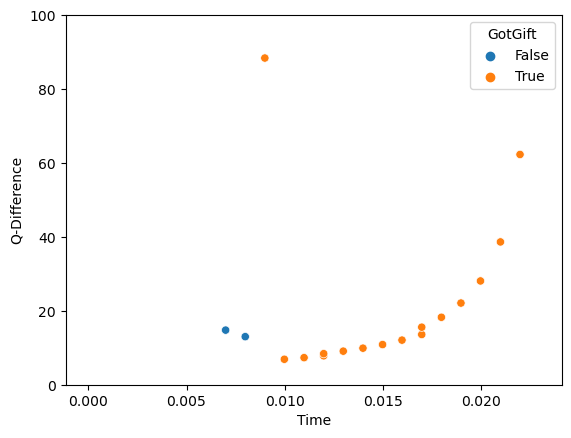

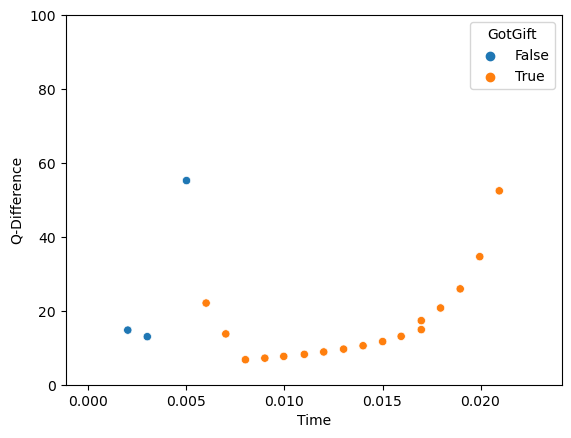

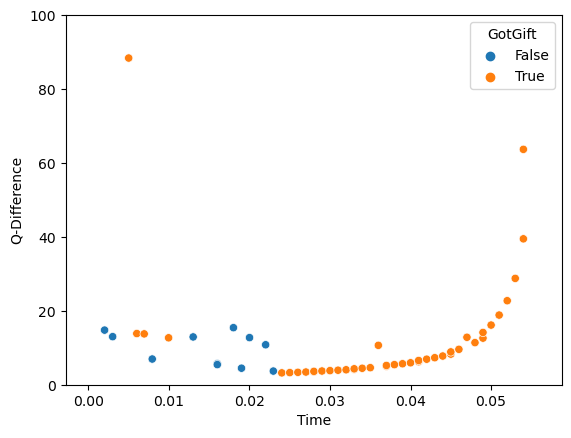

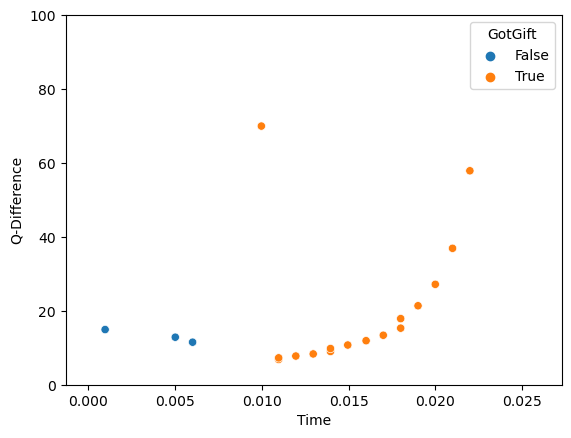

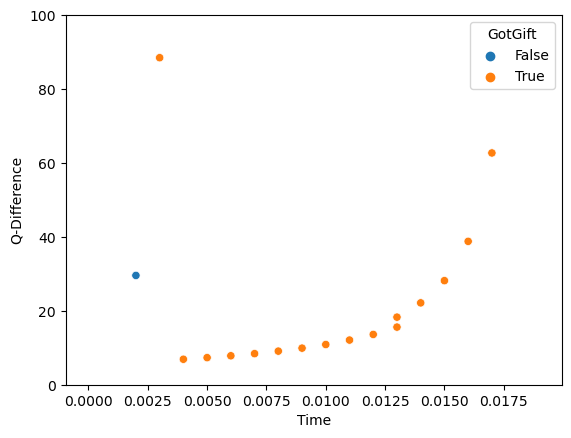

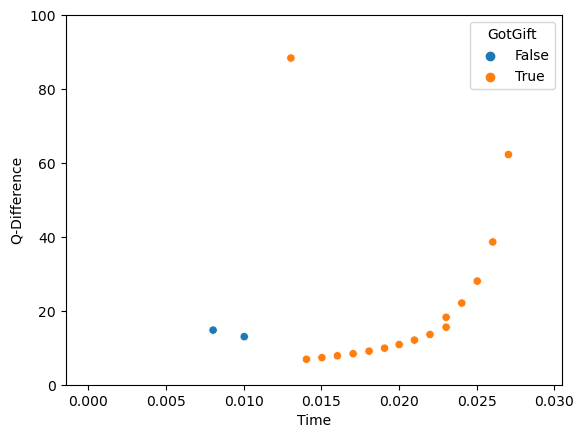

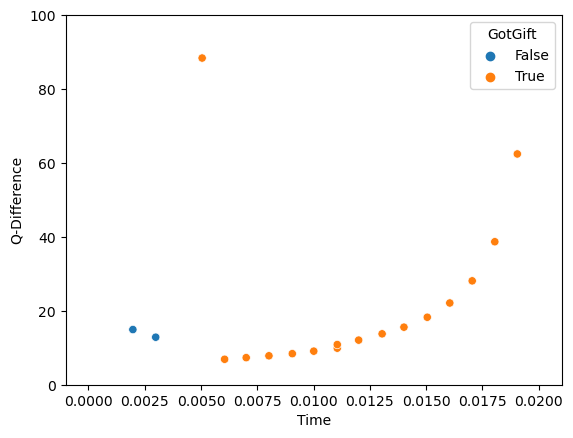

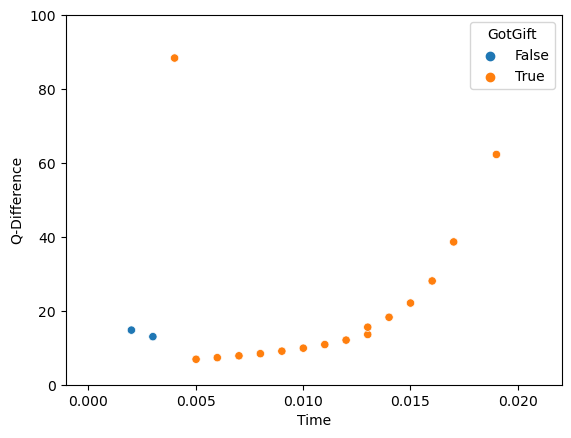

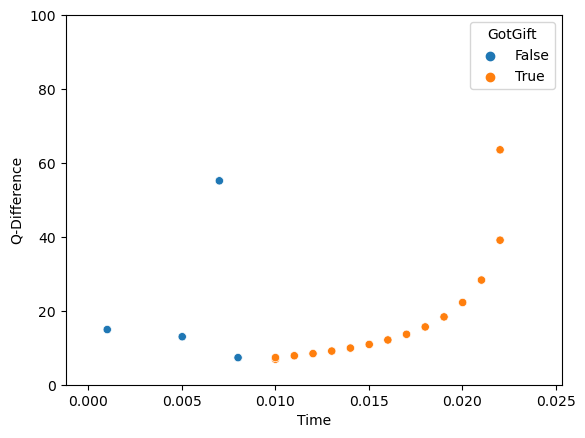

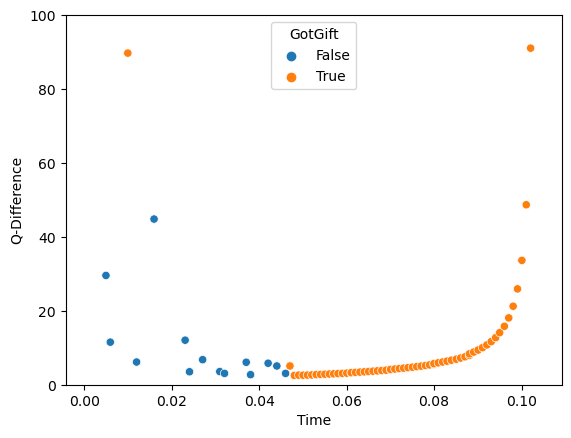

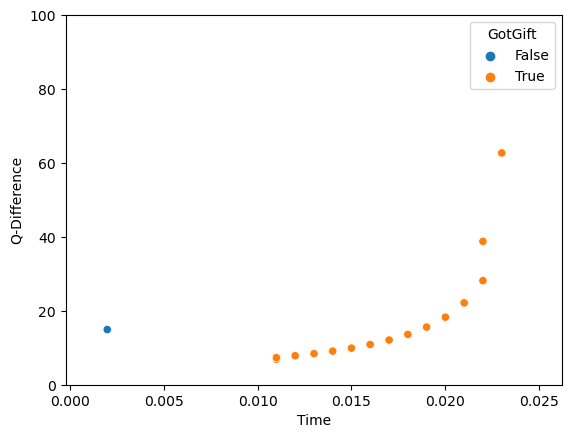

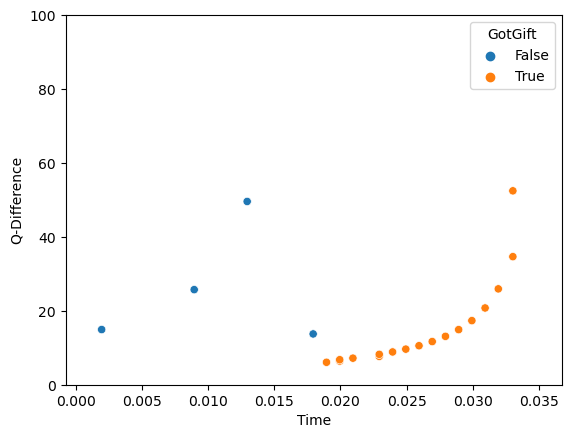

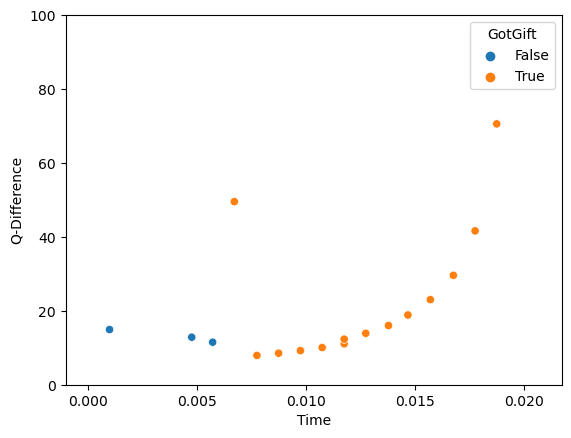

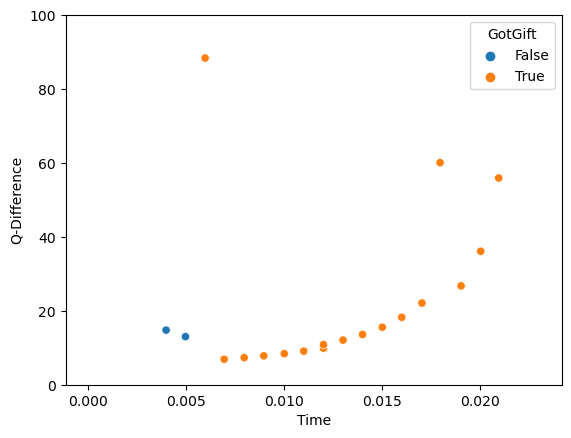

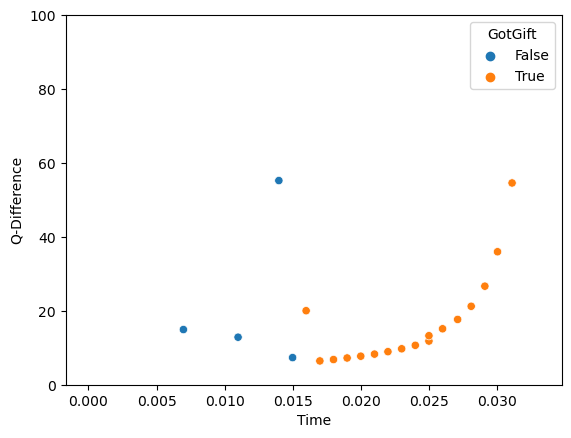

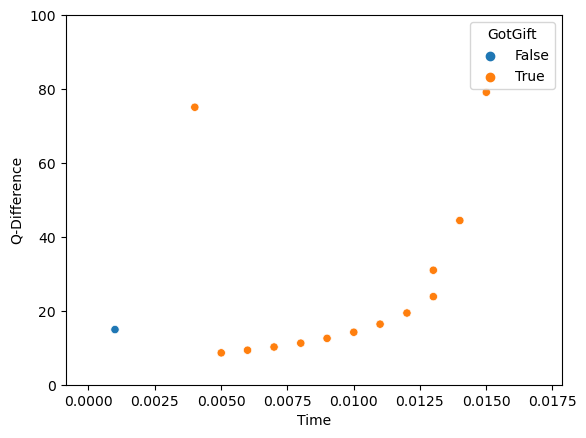

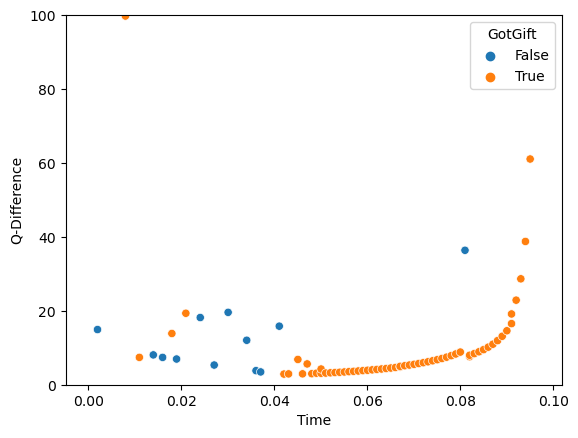

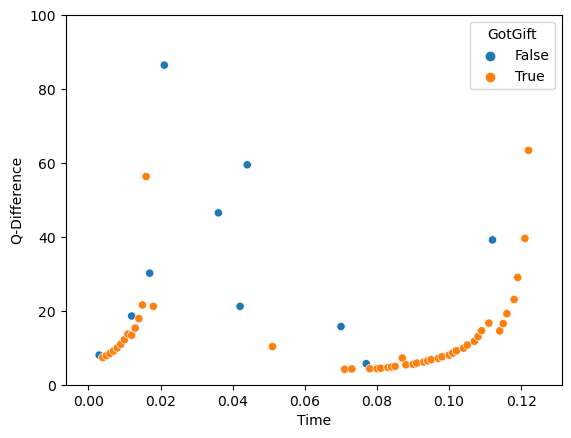

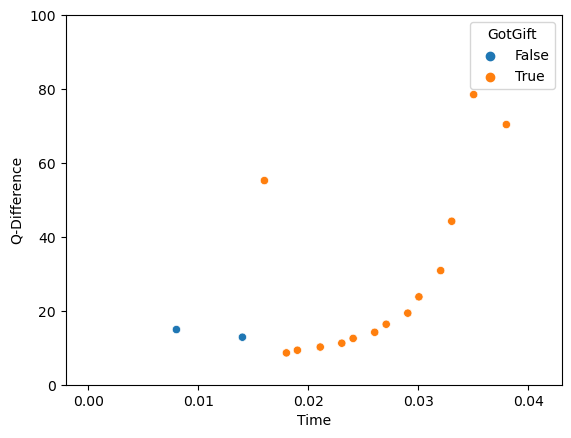

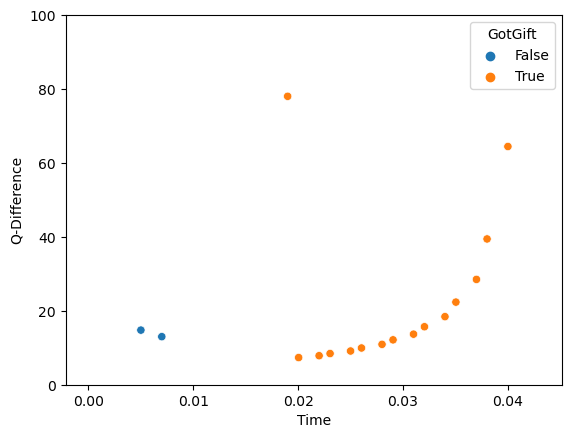

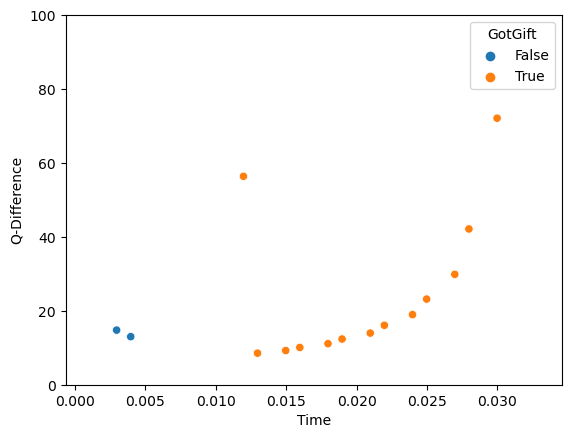

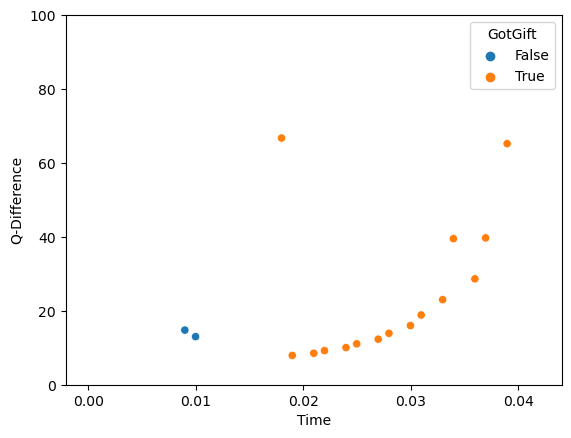

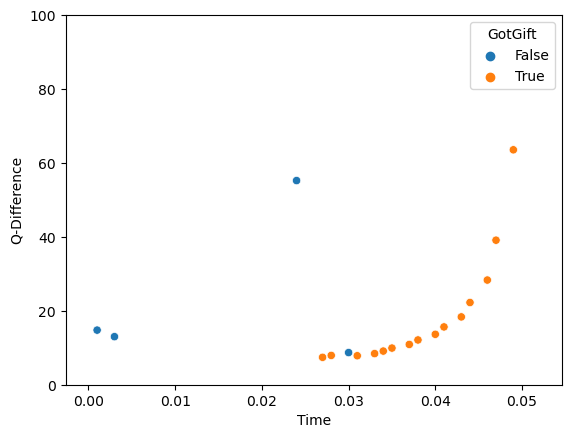

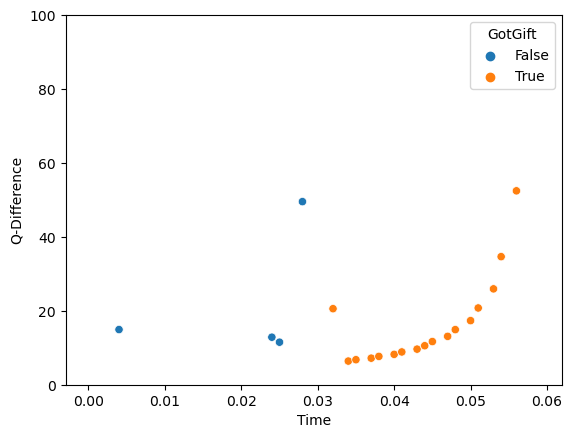

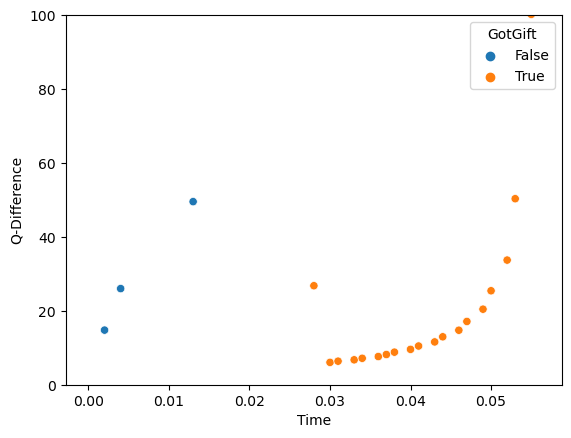

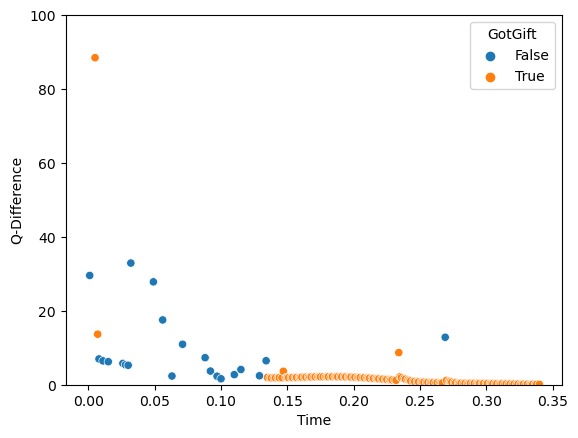

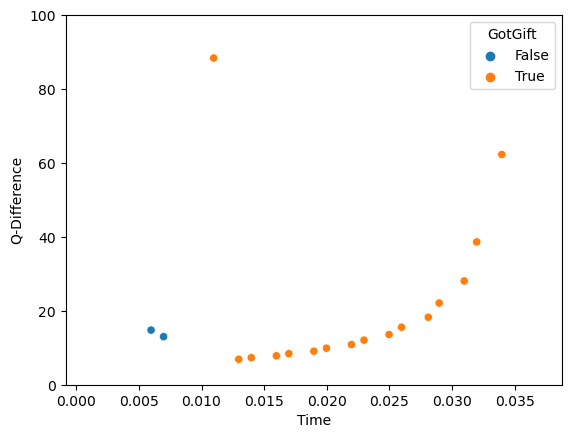

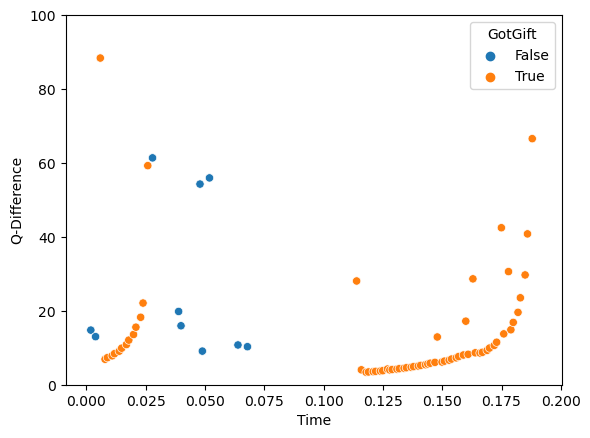

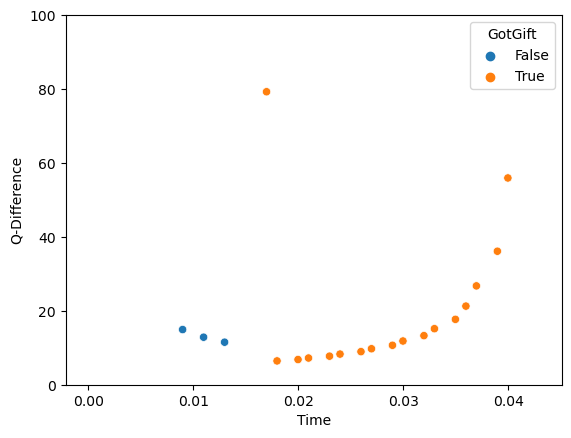

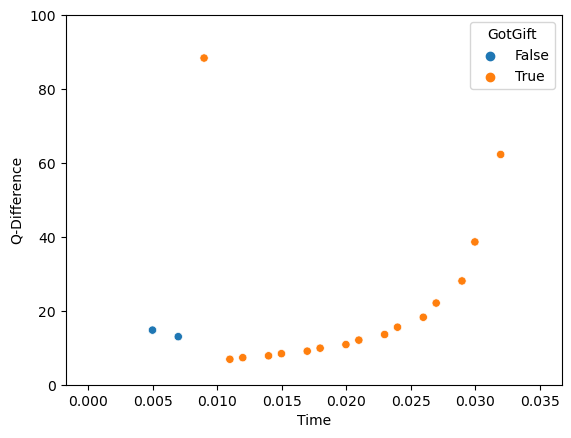

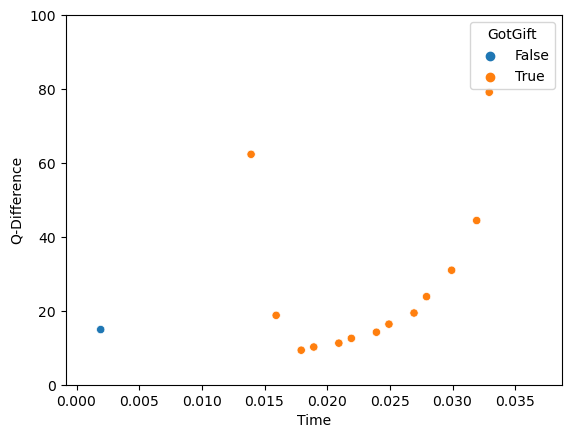

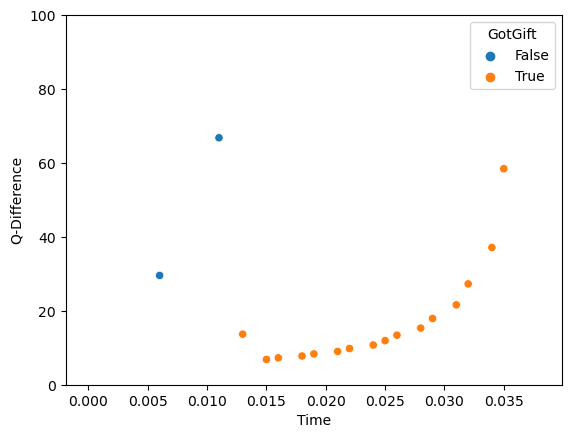

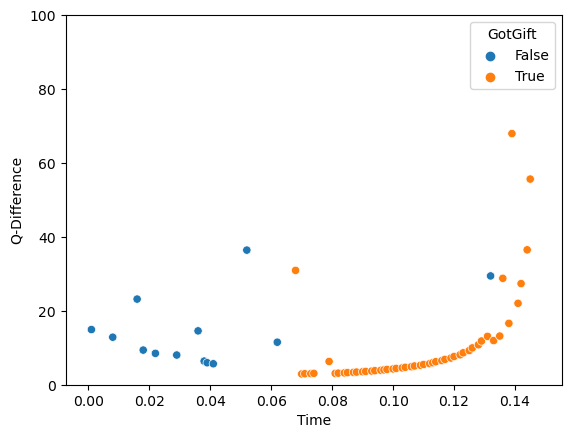

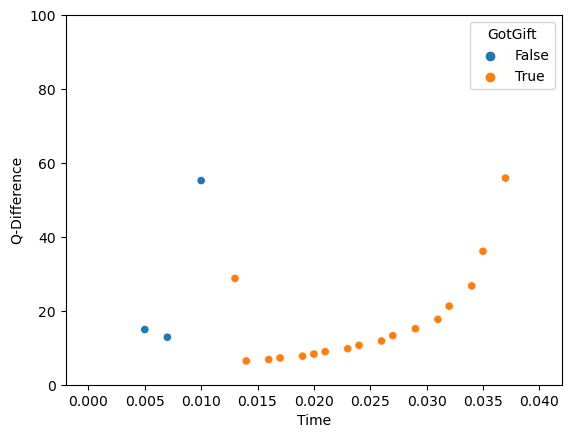

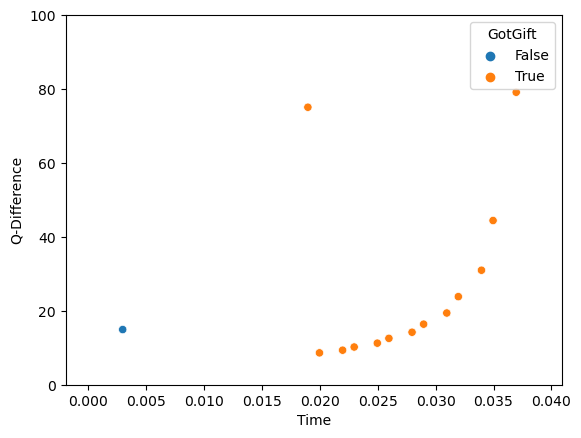

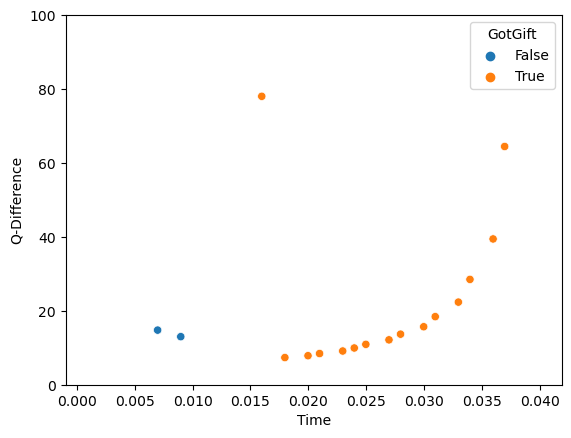

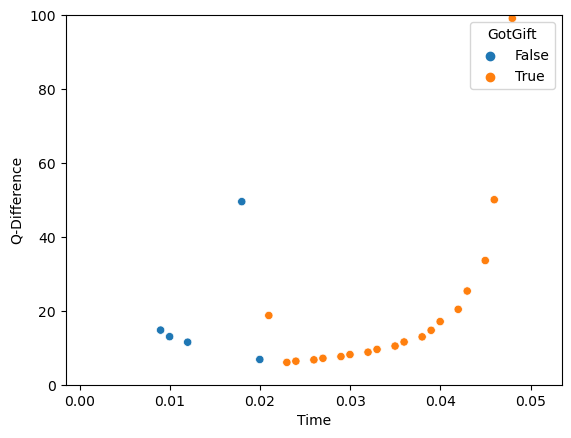

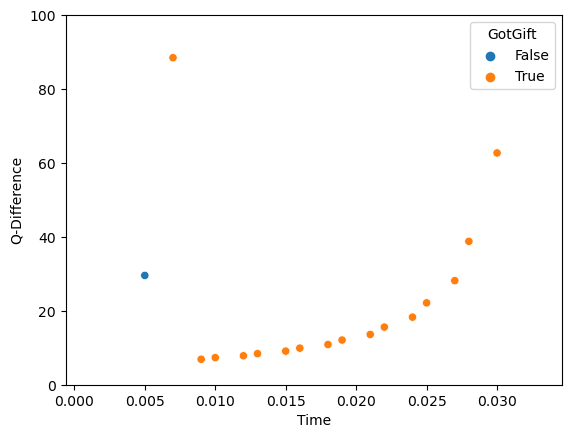

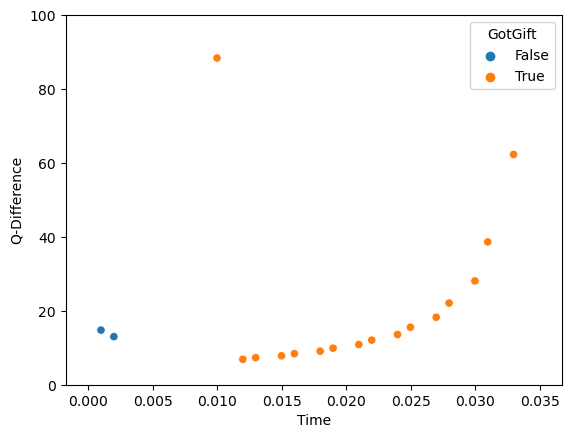

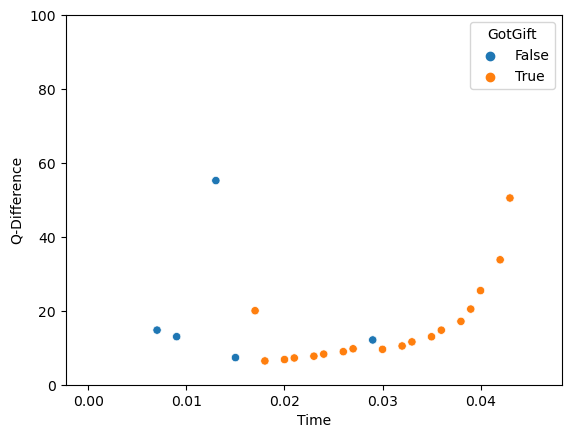

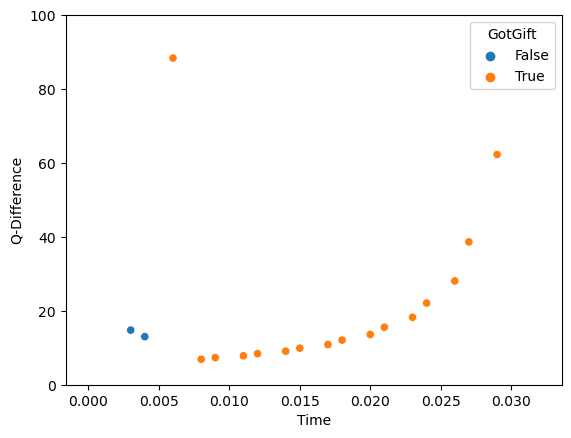

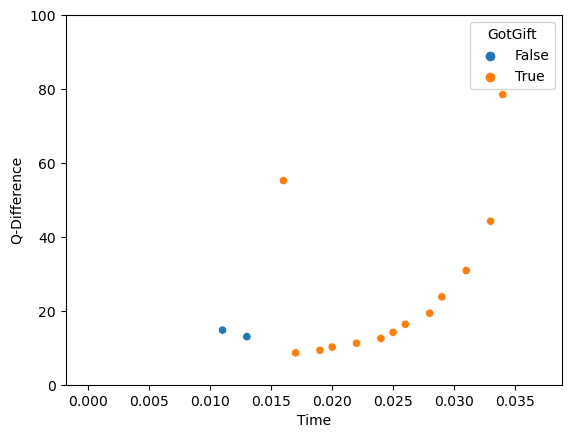

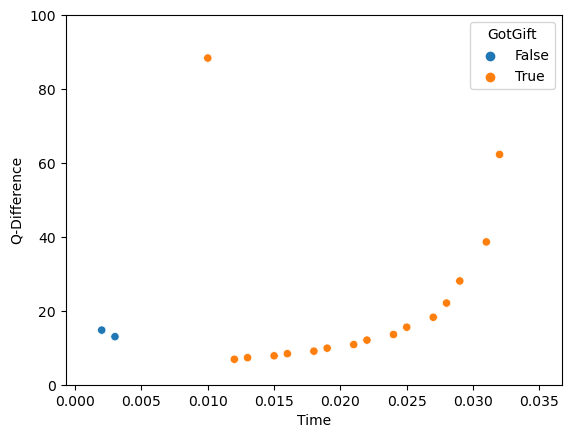

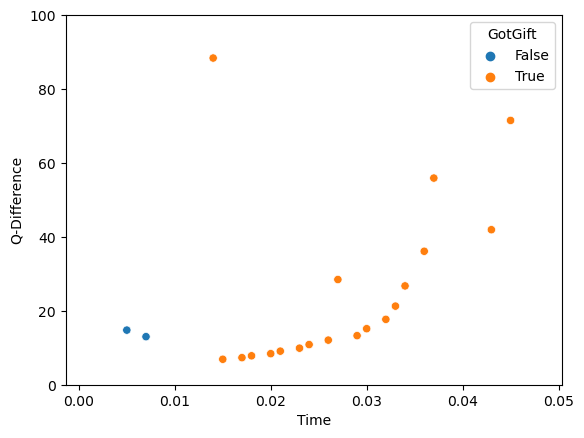

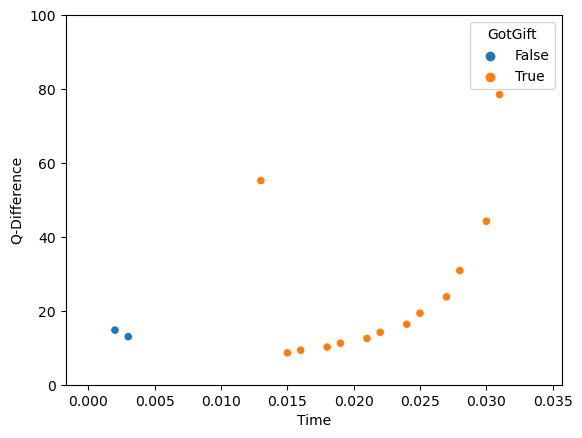

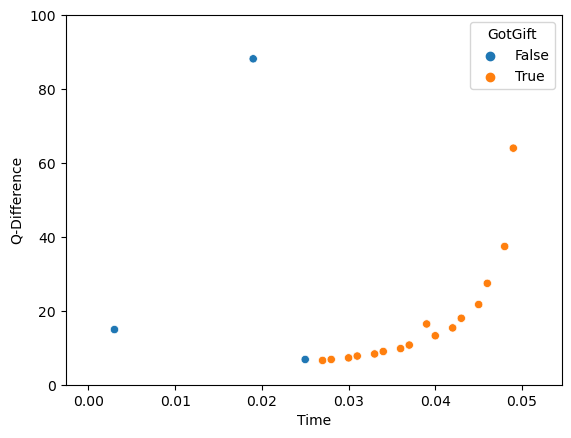

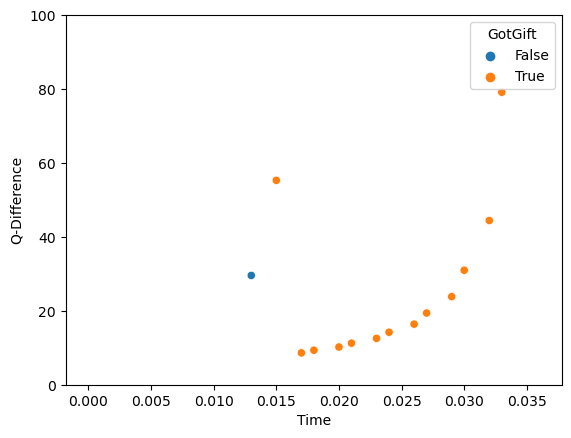

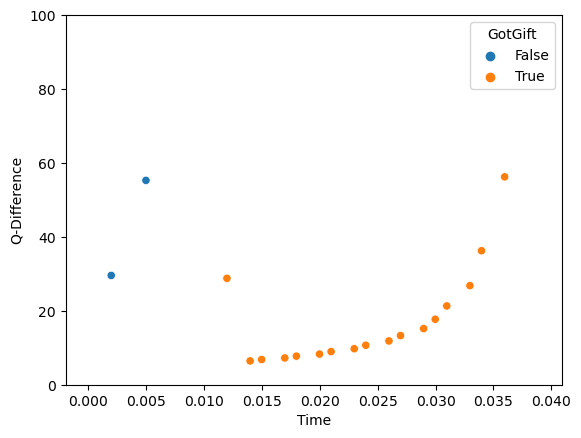

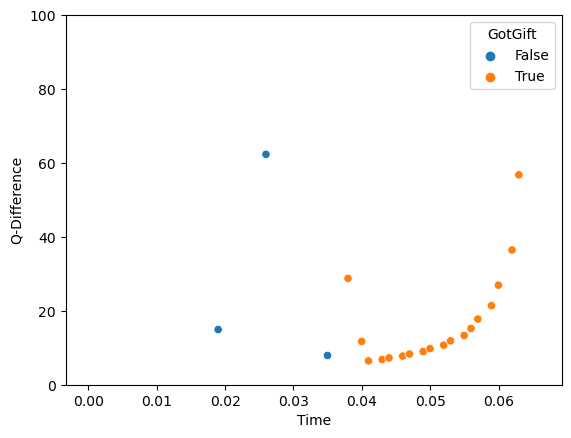

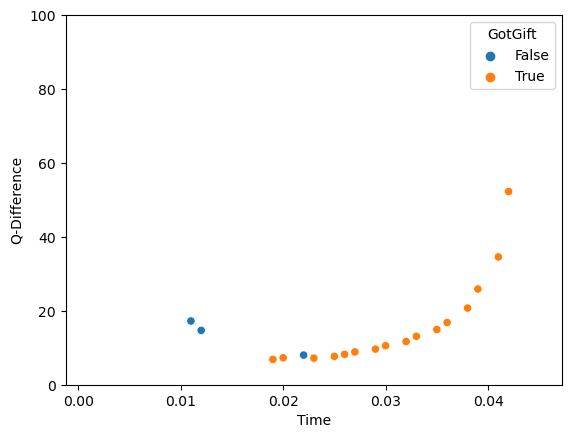

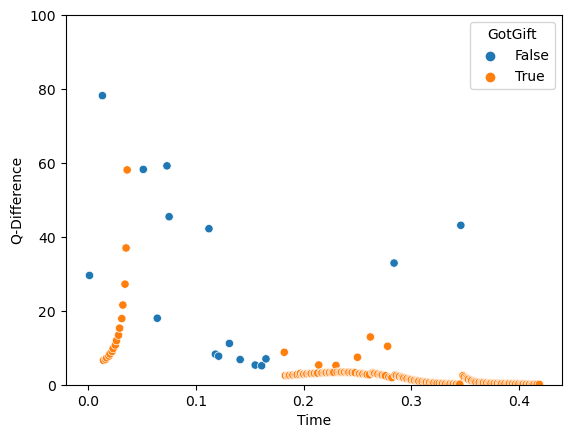

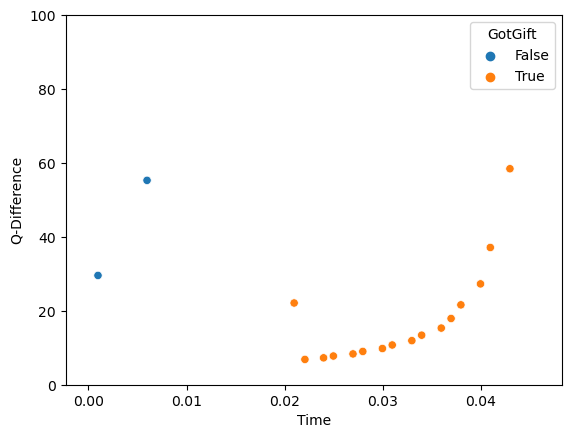

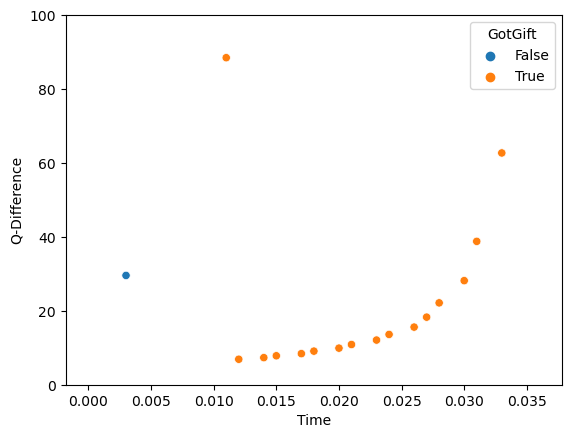

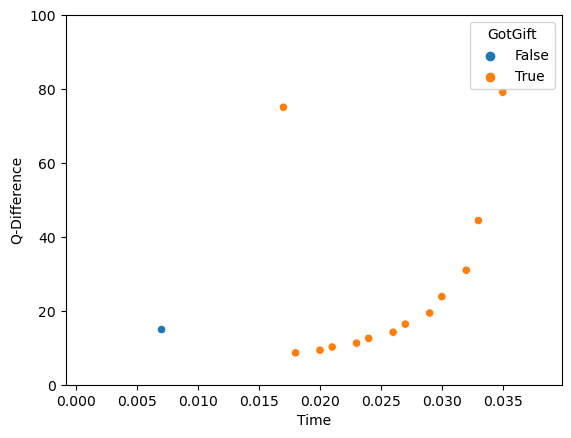

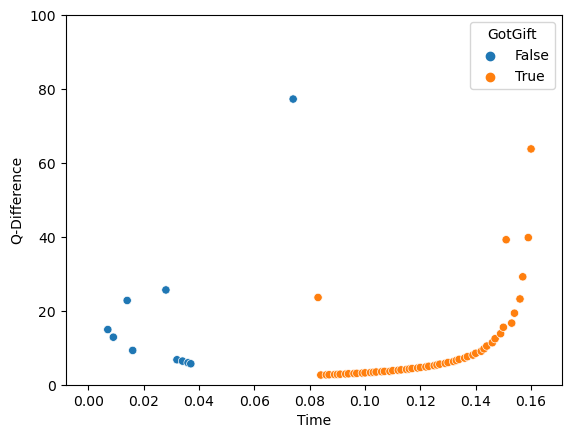

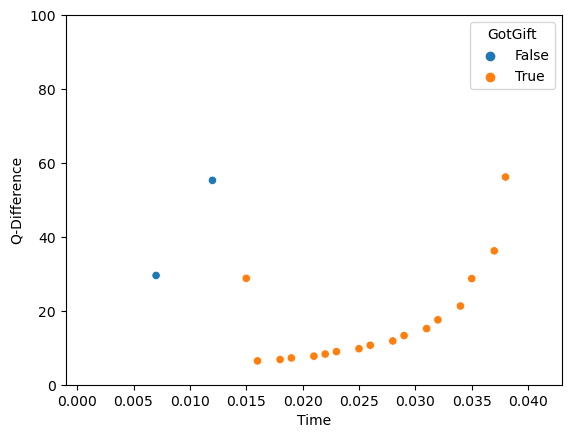

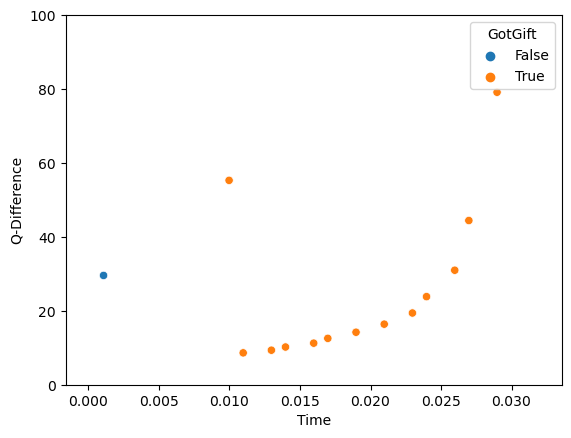

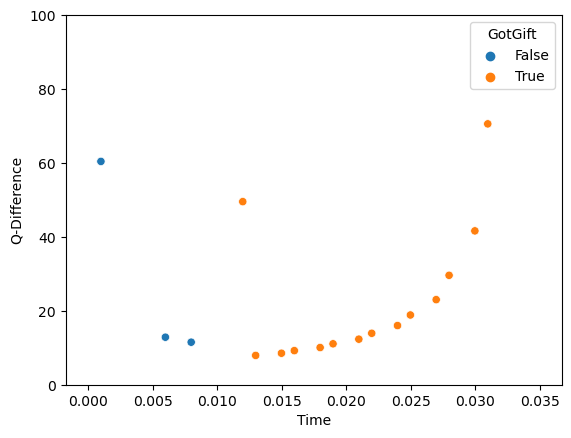

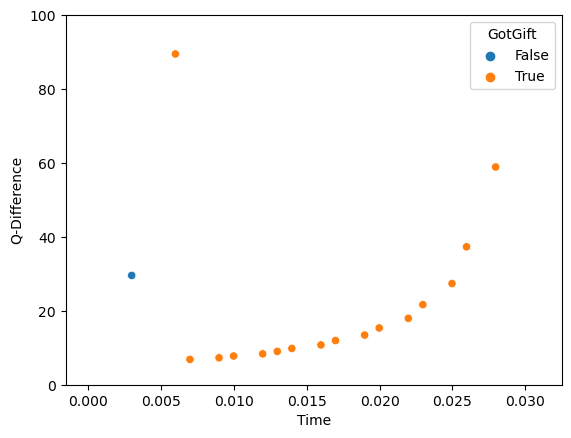

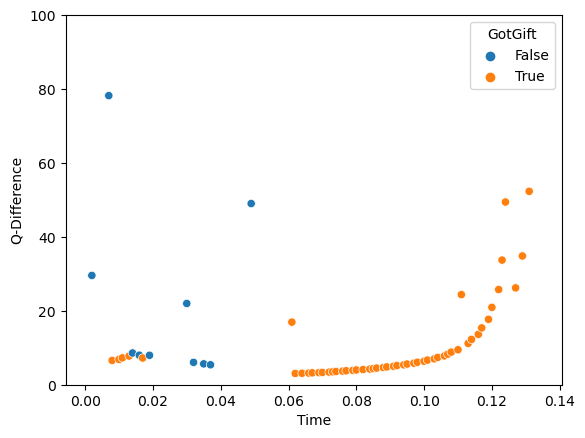

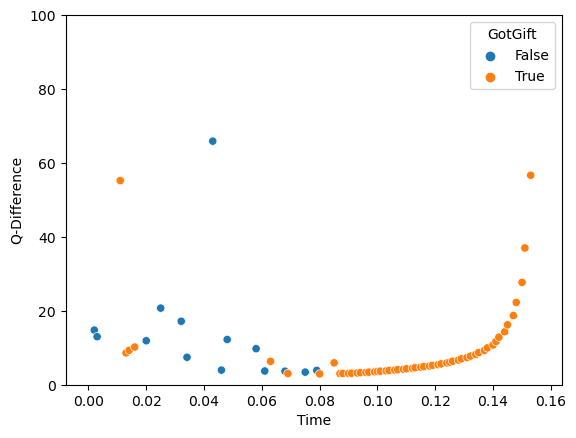

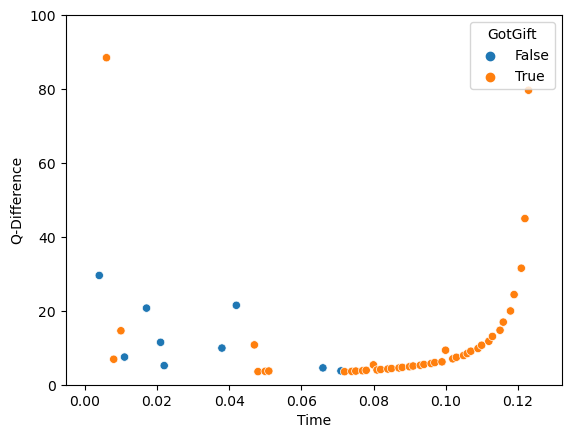

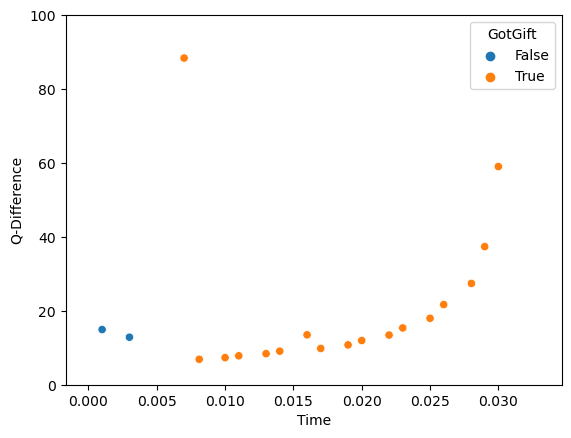

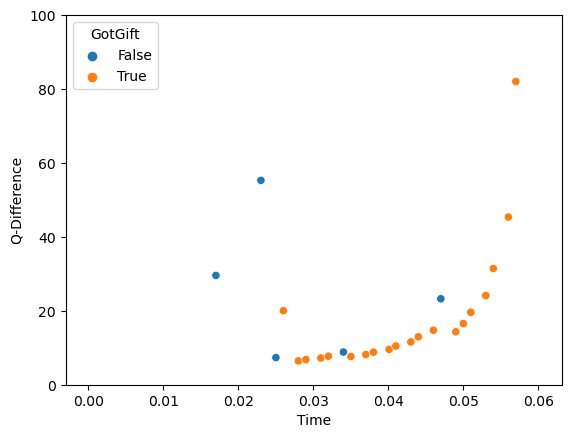

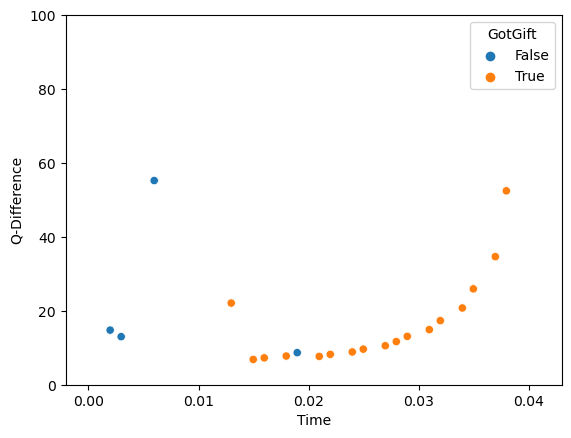

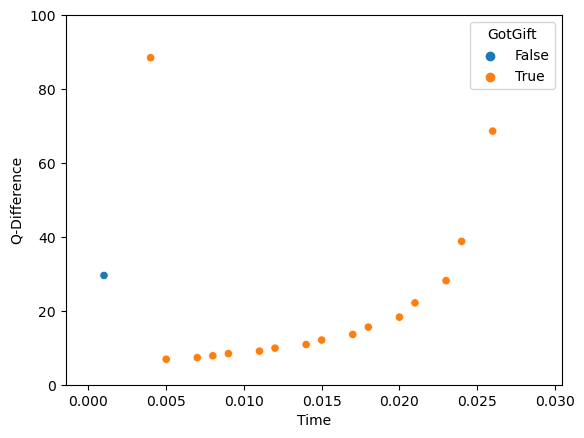

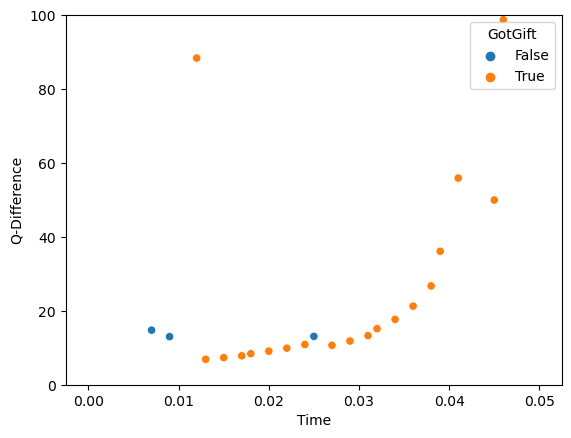

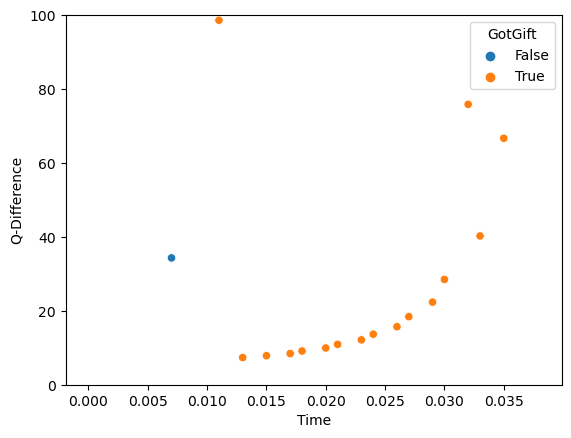

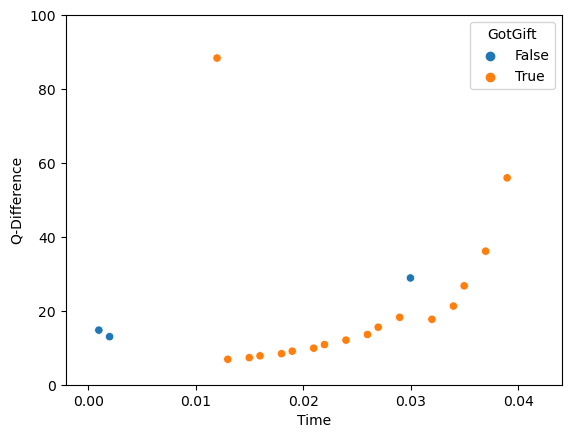

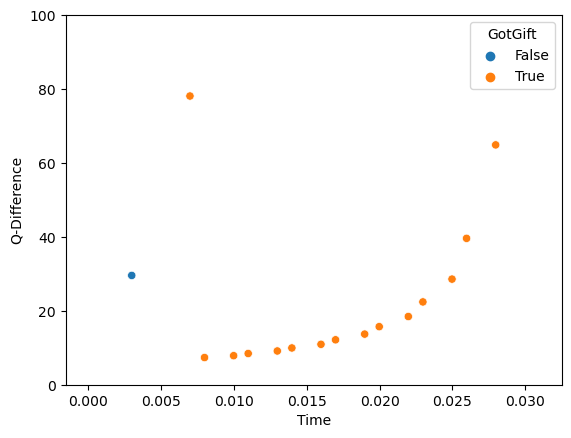

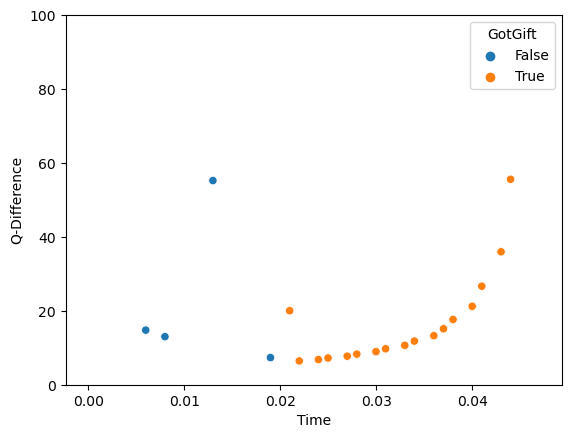

    Trial      Time  Episodes  Actions
0       1  0.026008        23      311
1       2  0.059108        53     1724
2       3  0.023916        18      779
3       4  0.020009        18      651
4       5  0.018997        21      272
..    ...       ...       ...      ...
95     96  0.050000        26      498
96     97  0.038001        20      512
97     98  0.041968        23      497
98     99  0.030974        19      335
99    100  0.047002        24      823

[100 rows x 4 columns]


In [5]:
trialTimes = pd.DataFrame(
    {
        "Trial": [],
        "Time": [],
        "Episodes": [],
        "Actions": []
    }
)

for i in range(100):
    data = runTrial()
    tim = data["Time"]
    episodes = data["Episodes"]
    actions = data['ActionCount']
    trialTimes.loc[i] = {
        "Trial": i+1,
        "Time": tim,
        "Episodes": episodes,
        "Actions": actions
    }
    
print(trialTimes)

In [6]:

avgTime = trialTimes["Time"].mean()
avgEpisodes = trialTimes["Episodes"].mean()
avgActions = trialTimes['Actions'].mean()
print("Data:\n\nAverage Time To Converge: "+str(avgTime)+" seconds\nAverage Episodes To Converge: "+str(avgEpisodes)+" episodes\nAverage Actions Taken Before Converging: "+str(avgActions)+"\nTotal Actions: "+str(trialTimes["Actions"].sum()))

Data:

Average Time To Converge: 0.05817725658416748 seconds
Average Episodes To Converge: 36.4 episodes
Average Actions Taken Before Converging: 1379.57
Total Actions: 137957


In [7]:
trialTimes.to_csv("SARSATrials.csv")